In [1]:
# Loading the required libraries
import sox
import os 
import glob
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import os
import glob
import librosa
from IPython.display import Audio
import numpy as np
import shutil




In [3]:
cd /Users/svarmit/Documents/CUSP/IOT/CUSP-GX6004.005_ML4Sound-master/

/Users/svarmit/Documents/CUSP/IOT/CUSP-GX6004.005_ML4Sound-master


**Step1 Downloading and understanding data **

Downloading the data from UrbanSound8K dataset: https://serv.cusp.nyu.edu/projects/urbansounddataset/

There are 10 different sound classes which are air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren and street_music.

** classID**
A numeric identifier of the sound class:
* 0 = air_conditioner
* 1 = car_horn
* 2 = children_playing
* 3 = dog_bark
* 4 = drilling
* 5 = engine_idling
* 6 = gun_shot
* 7 = jackhammer
* 8 = siren
* 9 = street_music


Before going further lame assumption is air_conditioner and engine_idling will be most confused as both sounds very similar and are consistant throughout the length of audio.



The dataset comes pre-sorted into 10 folds, named fold1 to fold10. I am using  folds as follows:
* 8 folds for training
* 1 fold for validation
* 1 fold for testing

The validation fold can be used to evaluate different features/models/hyper-parameters. This is done by training the model on the training folds (all combined), and testing on the validation fold. Once we have identified the optimal model configuration (features / model / model parameters), we can re-train your model using the training *and* validation folds combined, and finally evaluate the model on the test fold.

I am using fold 7 for validation and fold 6 for testing (selected randomly). For more precise machine learning algorithm I could have used cross validation technique for randomly selecting fold for validation and testing



** Step 2 : Pre-processing of data **

The audio files in UrbanSound8K are all in wav format, but have different sampling rates, bit depths and number of channels. Using the preprocessing code I am converting all audios to the following format:
* wav file
* sample rate: 44100
* bit depth: 16
* number of channels: 1



In [3]:
# Start of Step 2
# Code to save name of folders in 2 arrays (input_folder , output_folder)
input_folder = []
output_folder = []
for dirname, dirnames, filenames in os.walk('./UrbanSound8K/audio/'):
    for subdirname in dirnames:
        input_folder.append((os.path.join(dirname, subdirname)))
for dirname1, dirnames1, filenames1 in os.walk('./UrbanSound8K/audio_export/'):
    for subdirname1 in dirnames1:
        output_folder.append((os.path.join(dirname1, subdirname1)))
              

In [8]:
##cd UrbanSound8K/audio/fold1/

In [6]:
# Code for standardization of all sound files to wav file format, sample rate = 44100, bit depth = 16 and channels =1
i=0
out_format = 'wav'
out_sr = 44100
out_bitdepth = 16
out_channels = 1

# To automate the task to fetch files from all 10 folders as input_folder and automaticaly extract to output_folder
# Find all files in the input folder (they must all be audio files!)
for in_fol,out_fol in zip(input_folder,output_folder):
    audiofiles = glob.glob(os.path.join(in_fol, "*"))
# Convert each file in the folder
    for af in audiofiles:
        if os.path.isfile(af):
            outfile = os.path.join(out_fol, "{:s}.{:s}".format(os.path.basename(af)[:-4], out_format))
            tfm = sox.Transformer()
            tfm.convert(samplerate=out_sr,  bitdepth=out_bitdepth)
            i = i+1
            tfm.build(af,outfile)
    

**Step 3: Raw feature extraction **
librosa: Python library for audio and music analysis(https://github.com/librosa/librosa)

Using librosa to extract MFCC matrices from all the audio files in the dataset. For the MFCC computation I am using using
* A frame (window) size of 1024 samples
* A hop size of 512 samples
* 128 mel bands 
* keep the first 25 MFCC coefficients (not including coefficient 0).

**Tip**: feature extraction on a moderately large dataset such as this can take a long time. **It is strongly recommended** that you save the raw feaures (mfcc matrices) to disk so that you can easily load them and experiment with different feature summarization / classification models / model parameters without having to recompute the mfcc matrices each time. Assuming your ```matrix``` is a numpy ```ndarray```, an easy way to do this is: ```matrix.dump('filename.npy')```. Loading the data back is as simple as: ```matrix = np.load('filename.npy')```.

**Tip**: you can speed up the feature extraction process using multiprocessing:
For example, extracting the features for each fold in a parallel process would be roughly 10 times faster (if your machine has 10 cores or at least 5 cores with multithreading).

In [7]:
# defining variable value for Feature selection
samplerate = 44100
window_size = 1024
hop_size = 512
n_bands = 128
n_mfcc = 25

In [8]:
# Defining the folder where all the files to be trained will be stored
# Copying the files that will be used for training in the training folder(train_folder)
train_folder = './UrbanSound8K/train_files'
for dirname1, subdirname1, filenames1 in os.walk('./UrbanSound8K/audio_export/'):
    if dirname1 != ('./UrbanSound8K/audio_export/'):
        if dirname1!=('./UrbanSound8K/audio_export/fold6'): # excluding the files of validation set from training set
            if dirname1!=('./UrbanSound8K/audio_export/fold7'): # ecluding the testing data set files from training set
                print dirname1 # Print the directory name from which files will be copied to train_folder
                for files in os.listdir(dirname1):
                    SourceFolder = os.path.join(dirname1,files)
                    shutil.copy2(SourceFolder, train_folder)

./UrbanSound8K/audio_export/fold1
./UrbanSound8K/audio_export/fold10
./UrbanSound8K/audio_export/fold2
./UrbanSound8K/audio_export/fold3
./UrbanSound8K/audio_export/fold4
./UrbanSound8K/audio_export/fold5
./UrbanSound8K/audio_export/fold8
./UrbanSound8K/audio_export/fold9


In [9]:
train_folder

'./UrbanSound8K/train_files'

In [10]:
#Assigning the datapath of validation data set and testing dataset to the valid_folder and test_folder
valid_folder = './UrbanSound8K/audio_export/fold7/'
test_folder = './UrbanSound8K/audio_export/fold6/'


In [38]:
# Get a list of names of all the training audio files  in train_files(must be .WAV files)
train_files = glob.glob(os.path.join(train_folder, '*.wav'))

# Get a list of names all the test audio files (must be .WAV files) in test_files
test_files = glob.glob(os.path.join(test_folder, '*.wav'))

# Get a list of names of all the validation audio files (must be .WAV files) in valid_files
valid_files = glob.glob(os.path.join(valid_folder, '*.wav'))

# Specify the labels (classes) we're going to classify the data into
label0 = 'air_conditioner'
label1 = 'car_horn'
label2 = 'children_playing'
label3 = 'dog_bark'
label4 = 'drilling'
label5 = 'engine_idling'
label6 = 'gun_shot'
label7 = 'jackhammer'
label8 = 'siren'
label9 = 'street_musiclabel'
labels = ['air_conditioner','car_horn','children_playing','dog_bark','drilling','engine_idling','gun_shot','jackhammer','siren','street_musiclabel']

**Step 4: Feature processing **


Converting  raw features (mfcc matrices) into feature vectors and stacking them into a feature list, and create a correpsonding label list. For each of your three sets (training, validation, test), the following tasks are performed

<h4> Task 1 :</h4>
For every audio file, each coefficient time-series in the mfcc matrix (i.e. each row) is summarized using the following summary statistics: 
* mean
* standard deviation

Combine the sumamry statistics into a flat feature vector and add it to the feature list.

For every file label is figured out. The mapping from filename to label is provided in the UrbanSound8K.csv file (the "class" column) inside the metadata folder. Once the class of file is identified , it is maped to an integer label from 0 to (nclasses - 1). The recommended way to do this is creating a list of all the class labels and sorting it alphabetically. Then the integer label for each class name is its index (location) in the list.


<h4>Task 2 :</h4>
Now that the feature lists (and corresponding label lists) are computed, standardize the feature vectors across dimensions. The standardization parameters only are used as training data, and then same rules are apllied to all three sets: training, validation, and test.

In [39]:
print ('count of train files',len(train_files))
print ('count of validataion files ',len(valid_files))
print ('count of testing files ',len(test_files))


('count of train files', 7071)
('count of validataion files ', 838)
('count of testing files ', 823)


In [43]:
# Feature extraction of the training dataset
# Define lists to store the training features and corresponding training labels
train_features = []
train_labels = []

# For every audio file in the training set, load the file, compute MFCCs, summarize them over time
# using the mean and standard deviation (for each MFCC coefficient), and then save the features
# and corresponding label in the designated lists

for tf in train_files:
    
    # Load audio
    
    audio, sr = librosa.load(tf, sr=samplerate, mono=True)

    # Extract mfcc coefficients (remember we will discard the first one)
    # To see all the relevant kwarg arugments consult the documentation for
    # librosa.feature.mfcc, librosa.feature.melspectrogram and librosa.filters.mel
    mfcc = librosa.feature.mfcc(audio, sr=sr, n_fft=window_size, hop_length=hop_size,
                                fmax=samplerate/2, n_mels=n_bands, n_mfcc=(n_mfcc + 1))
          
    # Discard the first coefficient
    mfcc = mfcc[1:,:]
    #print("mfcc matrix shape: {:s}".format(mfcc.shape))
    
    # Summarize the time-series (per-frame values) for each mfcc coefficient:
    # Hint: we could also compute these statistics on the delta and delta-delta
    # time series. We could also compute more statistics from each time series!
    mfcc_means = np.mean(mfcc, 1)
    mfcc_stddevs = np.std(mfcc, 1)
    
    # We could do the same for the delta features like this:
    # mfcc_d1_means = np.mean(np.diff(mfcc), 1)
    # mfcc_d1_stddevs = np.std(np.diff(mfcc), 1)
    
    # Concatenate means and std. dev's into a single feature vector
    feature_vector = np.concatenate((mfcc_means, mfcc_stddevs), axis=0)
    #print("feature vector shape: {:s}".format(feature_vector.shape))
    
    # Get label for audio file from its filename and convert to integer based on 
    # its location in the label list defined at the beginning of Step 2
    tf_label = os.path.basename(tf).split('-')[1]
    #lab =  'label'+tf_label
    #print lab
    #tf_label_ind = labels.index(lab)
    #print("file label: {:s}".format(tf_label_ind))
    
    # Store the feature vector and corresponding label in integer format
    train_features.append(feature_vector)
    train_labels.append(tf_label)

train_features = np.asarray(train_features)
train_labels = np.asarray(train_labels)



In [48]:
# Feature extraction for the testing dataset
# Define lists to store the test features and corresponding test labels
test_features = []
test_labels = []

# For every audio file in the training set, load the file, compute MFCCs, summarize them over time
# using the mean and standard deviation (for each MFCC coefficient), and then save the features
# and corresponding label in the designated lists
for tf in test_files:
    
    # Load audio
    audio, sr = librosa.load(tf, sr=samplerate, mono=True)

    # Extract mfcc coefficients (remember we will discard the first one)
    # To see all the relevant kwarg arugments consult the documentation for
    # librosa.feature.mfcc, librosa.feature.melspectrogram and librosa.filters.mel
    mfcc = librosa.feature.mfcc(audio, sr=sr, n_fft=window_size, hop_length=hop_size,
                                fmax=samplerate/2, n_mels=n_bands, n_mfcc=(n_mfcc + 1))
          
    # Discard the first coefficient
    mfcc = mfcc[1:,:]
    #print("mfcc matrix shape: {:s}".format(mfcc.shape))
    
    # Summarize the time-series (per-frame values) for each mfcc coefficient:
    # Hint: we could also compute these statistics on the delta and delta-delta
    # time series. We could also compute more statistics from each time series!
    mfcc_means = np.mean(mfcc, 1)
    mfcc_stddevs = np.std(mfcc, 1)
    
    # We could do the same for the delta features like this:
    # mfcc_d1_means = np.mean(np.diff(mfcc), 1)
    # mfcc_d1_stddevs = np.std(np.diff(mfcc), 1)
    
    # Concatenate means and std. dev's into a single feature vector
    feature_vector = np.concatenate((mfcc_means, mfcc_stddevs), axis=0)
    
    
    # Get label for audio file from its filename and convert to integer based on 
    # its location in the label list defined at the beginning of Step 2
    tf_label = os.path.basename(tf).split('-')[1]
    #tf_label_ind = labels.index('label'+tf_label)
    
    
    # Store the feature vector and corresponding label in integer format
    test_features.append(feature_vector)
    test_labels.append(tf_label)
test_features = np.asarray(test_features)
test_labels = np.asarray(test_labels)

test_features.dump('test_features.npy')
test_labels.dump('test_labels.npy')

In [49]:
# Extracting features for validation dataset
# Define lists to store the valid features and corresponding valid labels
valid_features = []
valid_labels = []

# For every audio file in the training set, load the file, compute MFCCs, summarize them over time
# using the mean and standard deviation (for each MFCC coefficient), and then save the features
# and corresponding label in the designated lists
for tf in valid_files:
    
    # Load audio
    audio, sr = librosa.load(tf, sr=samplerate, mono=True)

    # Extract mfcc coefficients (remember we will discard the first one)
    # To see all the relevant kwarg arugments consult the documentation for
    # librosa.feature.mfcc, librosa.feature.melspectrogram and librosa.filters.mel
    mfcc = librosa.feature.mfcc(audio, sr=sr, n_fft=window_size, hop_length=hop_size,
                                fmax=samplerate/2, n_mels=n_bands, n_mfcc=(n_mfcc + 1))
          
    # Discard the first coefficient
    mfcc = mfcc[1:,:]
    #print("mfcc matrix shape: {:s}".format(mfcc.shape))
    
    # Summarize the time-series (per-frame values) for each mfcc coefficient:
    # Hint: we could also compute these statistics on the delta and delta-delta
    # time series. We could also compute more statistics from each time series!
    mfcc_means = np.mean(mfcc, 1)
    mfcc_stddevs = np.std(mfcc, 1)
    
    # We could do the same for the delta features like this:
    # mfcc_d1_means = np.mean(np.diff(mfcc), 1)
    # mfcc_d1_stddevs = np.std(np.diff(mfcc), 1)
    
    # Concatenate means and std. dev's into a single feature vector
    feature_vector = np.concatenate((mfcc_means, mfcc_stddevs), axis=0)
    
    
    # Get label for audio file from its filename and convert to integer based on 
    # its location in the label list defined at the beginning of Step 2
    tf_label = os.path.basename(tf).split('-')[1]
    #tf_label_ind = labels.index('label'+tf_label)
    
    
    # Store the feature vector and corresponding label in integer format
    valid_features.append(feature_vector)
    valid_labels.append(tf_label)
valid_features = np.asarray(valid_features)
valid_labels = np.asarray(valid_labels)

valid_features.dump('valid_features.npy')
valid_labels.dump('valid_labels.npy')

<h4> Step 4 , Task 2 :</h4>

In [52]:
# Standardization of the feature vectors and learning standardization parameters fro training set
# Create a scale object
scaler = sklearn.preprocessing.StandardScaler()

# Learn the parameters from the training data only
scaler.fit(train_features)

# Apply the learned parameters to the training and test sets:
train_features_scaled = scaler.transform(train_features)
test_features_scaled = scaler.transform(test_features)
valid_features_scaled = scaler.transform(valid_features)



Step 5: Experimenting on the validation set (3 points)


* Train a K nearest neighbours classifier using the training set with K=5 (5 neighbours).
* Test model on the validation set
* Finding classification accuracy?
* Displaying the confusion matrix and identifying Which classes are confused the most?
* Repeat the train/test procedure (always using the validation set for testing) using K = 3, 7, 13 to see How does the accuracy changes as a function of K and reasoning.

**Other models**
* Repeat the train/test procedure using each of the few more models:




In [53]:
# Use scikit-learn to train a model with the training features we've extracted

# using a K nearest neighbour classifier with K=5
clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)

# Fit (=train) the model
clf.fit(train_features_scaled, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [54]:
# Now lets predict the labels of the validation data!
predictions = clf.predict(valid_features_scaled)

In [55]:
# Checking the prediction array shape
predictions.shape

(838,)

In [56]:
# We can use sklearn to compute the accuracy score
accuracy = sklearn.metrics.accuracy_score(valid_labels, predictions)
print(accuracy)

0.510739856802


** Classification accuracy is 51.0 which is not good at all **

In [58]:
# Computation of the  confusion matrix:
cm = sklearn.metrics.confusion_matrix(valid_labels, predictions)
print(cm)

[[83  0 14  0  0  1  0  0  1  1]
 [ 2  9 10  2  0  0  0  0  0  5]
 [ 3  3 71  0  0  1  0  0  7 15]
 [ 0  0 21 65  2  0  4  2  0  6]
 [42  1  3  3 19  1  1  4  0 26]
 [20  0 32  0  1 44  0  4  0  5]
 [ 0  0  2  1  0  0 47  0  0  1]
 [43  0  0  0 15  0  0  6  1 11]
 [ 1  2  7  0  0  2  0 10 42 13]
 [10  0 44  0  0  0  0  0  4 42]]


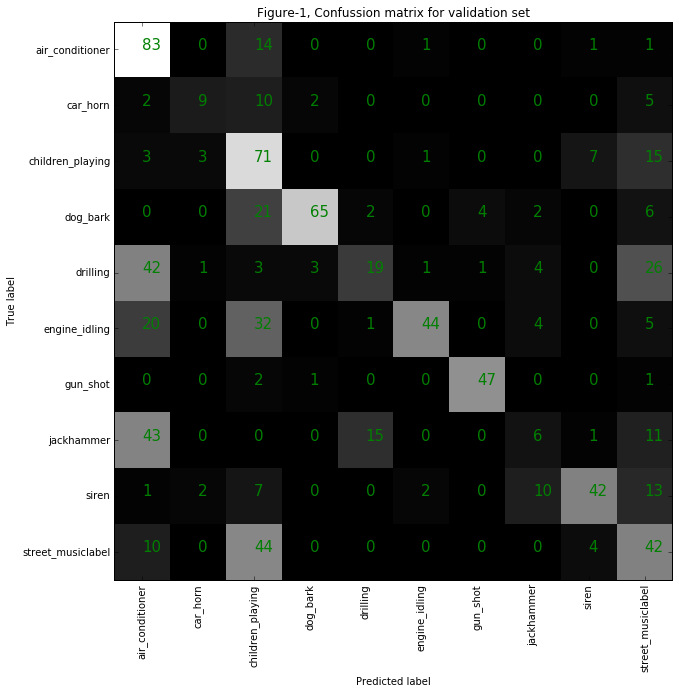

In [59]:
# better graphical presentation of the confussion matrix with label names
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(cm, interpolation='nearest', cmap='gray')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=15, color='green')
ax.set_xticks(range(len(cm)))
ax.set_xticklabels(labels,rotation='vertical')
ax.set_yticks(range(len(cm)))
ax.set_yticklabels(labels)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
ax.set_title('Figure-1, Confussion matrix for validation set')
plt.show()

Figure-1 shows the confussion matrix. The most confused class are Jackhammer and car horn(label 7,label 1 )

**Step 2 :**
* Repeat the train/test procedure (always using the validation set for testing) using K = 3, 7, 13.


In [60]:
# For K = 3, 7 and 13
k = [3,7,13]
for i in k:
    
    clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=i)

# Fit (=train) the model
    clf.fit(train_features_scaled, train_labels)
    predictions = clf.predict(valid_features_scaled)
    accuracy = sklearn.metrics.accuracy_score(valid_labels, predictions)
    print 'accuracy for k =',i,'=', (accuracy)

accuracy for k = 3 = 0.516706443914
accuracy for k = 7 = 0.514319809069
accuracy for k = 13 = 0.509546539379


Accuracy does not change much for k =3 and 7 but reduces for k =13 as there are 10 labels and finding nearest 13 neighbours can include neighbours in the group which actully are away or does not belong to group but forecfully had to be included in order to make k=13.


* Repeating the train/test procedure using each of the following models:
    * Support Vector Machine with a radial basis function kernel.
    * Random Forest with 500 trees



In [61]:

# Using the Support Vector Machine with a radial basis function kernel
# Checking the accuracy with few different values of C(just for looking at the impact of C )

accuracy_svm_list =[] # For storing the accuracy values at different C
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
C_2d_range = [0.001, 1, 100]
for C in C_2d_range:
    svm = SVC(C=C, cache_size=200, class_weight=None, coef0=0.0,
decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
max_iter=-1, probability=False, random_state=None, shrinking=True,
tol=0.001, verbose=False)
    svm.fit(train_features_scaled, train_labels)
    predictions_svm = svm.predict(valid_features_scaled)
    accuracy_svm = sklearn.metrics.accuracy_score(valid_labels, predictions_svm)
    print 'accuracy for SVM with c=',C,  (accuracy_svm)
    accuracy_svm_list.append(accuracy_svm)

accuracy for SVM with c= 0.001 0.090692124105
accuracy for SVM with c= 1 0.652744630072
accuracy for SVM with c= 100 0.674224343675


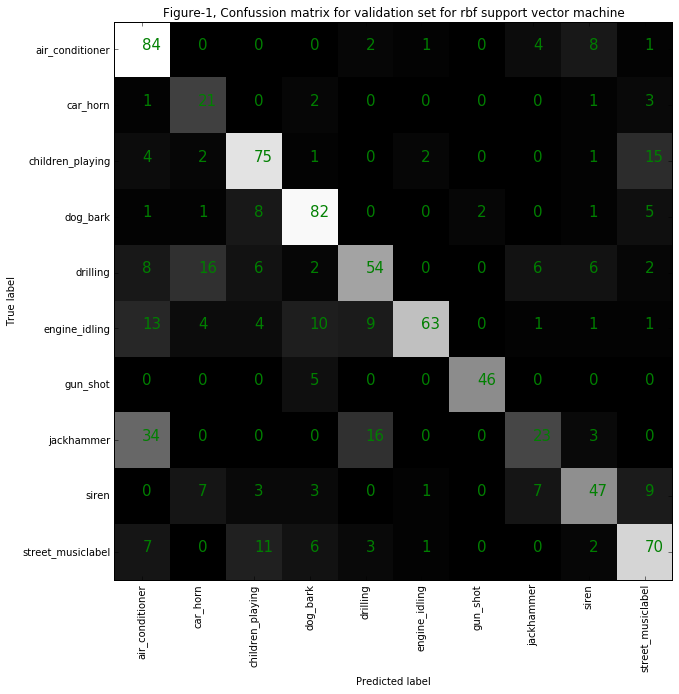

In [62]:
# Plotting the confussion matrix for SVM results.
cm = sklearn.metrics.confusion_matrix(valid_labels, predictions_svm)
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(cm, interpolation='nearest', cmap='gray')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=15, color='green')
ax.set_xticks(range(len(cm)))
ax.set_xticklabels(labels,rotation='vertical')
ax.set_yticks(range(len(cm)))
ax.set_yticklabels(labels)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
ax.set_title('Figure-1, Confussion matrix for validation set for rbf support vector machine')
plt.show()

*** Random Forest with 500 Trees ***

In [63]:
# Random Forest with 500 trees
from sklearn.ensemble import RandomForestClassifier
rmf = RandomForestClassifier(n_estimators=500, max_depth=None,min_samples_split=1, random_state=0)
rmf.fit(train_features_scaled, train_labels)
predictions_rmf = rmf.predict(valid_features_scaled)
accuracy_rmf = sklearn.metrics.accuracy_score(valid_labels, predictions_rmf)
print 'accuracy for random forest = ', (accuracy_rmf)


accuracy for random forest =  0.59307875895


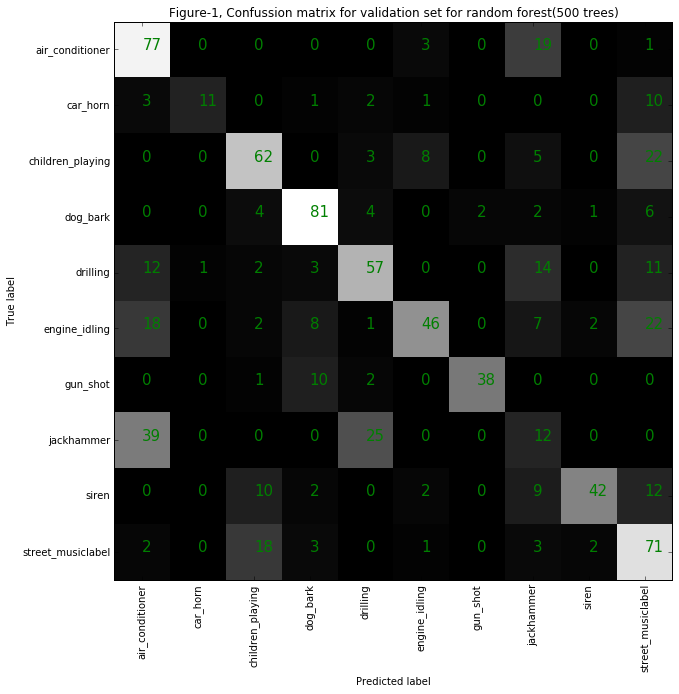

In [64]:
# Plotting the confussion matrix for Random forest results.
cm = sklearn.metrics.confusion_matrix(valid_labels, predictions_rmf)
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(cm, interpolation='nearest', cmap='gray')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=15, color='green')
ax.set_xticks(range(len(cm)))
ax.set_xticklabels(labels,rotation='vertical')
ax.set_yticks(range(len(cm)))
ax.set_yticklabels(labels)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
ax.set_title('Figure-1, Confussion matrix for validation set for random forest(500 trees)')
plt.show()

Both the models performed better than the nearest neighbour classifier in terms of accuracy. The confussion matrix for all the tree are different but the jackhammer identified as airconditioner are maximum in all 3 cases. 


jackhammer --> label7  

airconditioner --> label0 


**Step 6: Playing with the features for better results**

Repeat steps 1 and 2 of Task 4, modifying them to obtain an extended set of summary statistics:
* mean
* standard deviation
* **mean of the delta mfcc**
* **standard deviation of the delta mfcc**

Train/test the model (using the validation set for testing) using the model that gave you the best performance in Task 5.



In [68]:
# Define lists to store the training features and corresponding training labels
train_features = []
train_labels = []

# For every audio file in the training set, load the file, compute MFCCs, summarize them over time
# using the mean and standard deviation (for each MFCC coefficient), and then save the features
# and corresponding label in the designated lists

# Save all the matrix in the corresponding file as .npy file in local machine

for tf in train_files:
    
    
    audio, sr = librosa.load(tf, sr=samplerate, mono=True)

    mfcc = librosa.feature.mfcc(audio, sr=sr, n_fft=window_size, hop_length=hop_size,
                                fmax=samplerate/2, n_mels=n_bands, n_mfcc=(n_mfcc + 1))
    mfcc = mfcc[1:,:]
    mfcc_means = np.mean(mfcc, 1)
    mfcc_stddevs = np.std(mfcc, 1)
    
    # We could do the same for the delta features like this:
    mfcc_d1_means = np.mean(np.diff(mfcc), 1)
    mfcc_d1_stddevs = np.std(np.diff(mfcc), 1)
    mfcc_d2_means = np.mean(np.diff(np.diff(mfcc)), 1)
    mfcc_d2_stddevs = np.std(np.diff(np.diff(mfcc)), 1)
    
    # Concatenate means and std. dev's into a single feature vector
    feature_vector = np.concatenate((mfcc_means, mfcc_stddevs, mfcc_d1_means,mfcc_d1_stddevs,mfcc_d2_means,mfcc_d2_stddevs ), axis=0)
    #print("feature vector shape: {:s}".format(feature_vector.shape))
    
    tf_label = os.path.basename(tf).split('-')[1]
    #print 'label'+tf_label
    #tf_label_ind = labels.index('label'+tf_label)
    #print("file label: {:d}".format(tf_label_ind))
    
    # Store the feature vector and corresponding label in integer format
    train_features.append(feature_vector)
    train_labels.append(tf_label)

train_features = np.asarray(train_features)
train_labels = np.asarray(train_labels)

train_features.dump('train_features.npy')
train_labels.dump('train_labels.npy')

In [69]:
# Define lists to store the test features and corresponding test labels
test_features = []
test_labels = []

for tf in test_files:
    
    # Load audio
    audio, sr = librosa.load(tf, sr=samplerate, mono=True)

    mfcc = librosa.feature.mfcc(audio, sr=sr, n_fft=window_size, hop_length=hop_size,
                                fmax=samplerate/2, n_mels=n_bands, n_mfcc=(n_mfcc + 1))
          
    # Discard the first coefficient
    mfcc = mfcc[1:,:]
    #print("mfcc matrix shape: {:s}".format(mfcc.shape))
    
    mfcc_means = np.mean(mfcc, 1)
    mfcc_stddevs = np.std(mfcc, 1)
    
    # We could do the same for the delta features like this:
    mfcc_d1_means = np.mean(np.diff(mfcc), 1)
    mfcc_d1_stddevs = np.std(np.diff(mfcc), 1)
    mfcc_d2_means = np.mean(np.diff(np.diff(mfcc)), 1)
    mfcc_d2_stddevs = np.std(np.diff(np.diff(mfcc)), 1)
    
    # Concatenate means and std. dev's into a single feature vector
    feature_vector = np.concatenate((mfcc_means, mfcc_stddevs, mfcc_d1_means,mfcc_d1_stddevs,mfcc_d2_means,mfcc_d2_stddevs ), axis=0)
    
    
    tf_label = os.path.basename(tf).split('-')[1]
    #tf_label_ind = labels.index('label'+tf_label)
    
    
    # Store the feature vector and corresponding label in integer format
    test_features.append(feature_vector)
    test_labels.append(tf_label)
test_features = np.asarray(test_features)
test_labels = np.asarray(test_labels)

test_features.dump('test_features.npy')
test_labels.dump('test_labels.npy')

In [70]:
# Define lists to store the valid features and corresponding valid labels
valid_features = []
valid_labels = []

# For every audio file in the training set, load the file, compute MFCCs, summarize them over time
# using the mean and standard deviation (for each MFCC coefficient), and then save the features
# and corresponding label in the designated lists
for tf in valid_files:
    
    # Load audio
    audio, sr = librosa.load(tf, sr=samplerate, mono=True)

    mfcc = librosa.feature.mfcc(audio, sr=sr, n_fft=window_size, hop_length=hop_size,
                                fmax=samplerate/2, n_mels=n_bands, n_mfcc=(n_mfcc + 1))
          
    mfcc = mfcc[1:,:]
    mfcc_means = np.mean(mfcc, 1)
    mfcc_stddevs = np.std(mfcc, 1)
    
    # We could do the same for the delta features like this:
    mfcc_d1_means = np.mean(np.diff(mfcc), 1)
    mfcc_d1_stddevs = np.std(np.diff(mfcc), 1)
    mfcc_d2_means = np.mean(np.diff(np.diff(mfcc)), 1)
    mfcc_d2_stddevs = np.std(np.diff(np.diff(mfcc)), 1)
    
    # Concatenate means and std. dev's into a single feature vector
    feature_vector = np.concatenate((mfcc_means, mfcc_stddevs,mfcc_d1_means,mfcc_d1_stddevs,mfcc_d2_means,mfcc_d2_stddevs), axis=0)
    
    
    tf_label = os.path.basename(tf).split('-')[1]
    #tf_label_ind = labels.index('label'+tf_label)
    
    
    # Store the feature vector and corresponding label in integer format
    valid_features.append(feature_vector)
    valid_labels.append(tf_label)
valid_features = np.asarray(valid_features)
valid_labels = np.asarray(valid_labels)

valid_features.dump('valid_features_new.npy')
valid_labels.dump('valid_labels_new.npy')

In [71]:
# Create a scale object
scaler = sklearn.preprocessing.StandardScaler()

# Learn the parameters from the training data only
scaler.fit(train_features)

# Apply the learned parameters to the training and test sets:
train_features_scaled = scaler.transform(train_features)
valid_features_scaled = scaler.transform(valid_features)
test_features_scaled =  scaler.transform(test_features)




Train/test the model (using the validation set for testing) using the model that gave you the best performance in Step 5.


In [72]:
# Using the Support Vector Machine with a radial basis function kernel
# Checking the accuracy with few different values of C and gamma
svm = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
max_iter=-1, probability=False, random_state=None, shrinking=True,
tol=0.001, verbose=False)
svm.fit(train_features_scaled, train_labels)
predictions_svm = svm.predict(valid_features_scaled)
accuracy_svm = sklearn.metrics.accuracy_score(valid_labels, predictions_svm)
print 'accuracy for SVM = ', (accuracy_svm)
accuracy_svm_list.append(accuracy_svm)

accuracy for SVM =  0.659904534606


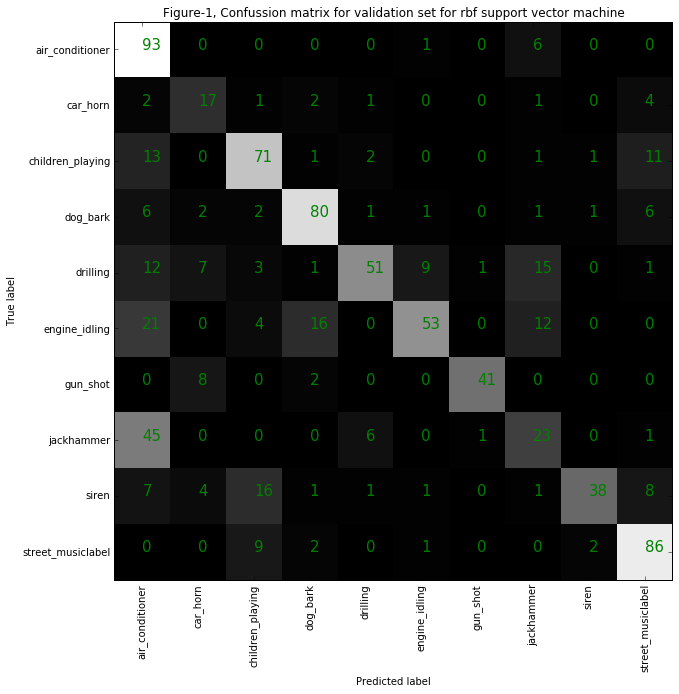

In [73]:
# Plotting the confussion matrix for SVM results.
cm = sklearn.metrics.confusion_matrix(valid_labels, predictions_svm)
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(cm, interpolation='nearest', cmap='gray')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=15, color='green')
ax.set_xticks(range(len(cm)))
ax.set_xticklabels(labels,rotation='vertical')
ax.set_yticks(range(len(cm)))
ax.set_yticklabels(labels)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
ax.set_title('Figure-1, Confussion matrix for validation set for rbf support vector machine')
plt.show()

Task 7: Model evaluation using the test set 
--

Now that we've finished experimenting with the features and the models and (hopefully) identified the best combination using the validation set, it's time to evaluate the model on the test set.

** Step 1, quantitative analysis (1 point):**
* Using the best feature set identified in previous tasks, combine the training and validation sets into a single large training set
* Use the combined training set to train the best model identified in Task 5.
* Test the model using the **test set**
* **Q7.1**: How did your model perform? Discuss in terms of accuracy and confusion.
* **Q7.2**: Did the model perform better or worse than you expected? Why?

**Step 2: qualitative analysis (1 point):**
* Choose 3 audio files that were miss-classified in Step 1 (each file should correspond to a different sound class)
* **Q7.3**: Listen to each file and suggest a possible explanation for why the model miss-classified it based on how it sounds.

In [34]:
# Combining the Training and validation set into single data single large training data set.
# Code to copy the validation files to the training folder
copy_count = 0
for files in os.listdir(valid_folder):
        SourceFolder = os.path.join(valid_folder,files)
        shutil.copy2(SourceFolder, train_folder)
        copy_count = copy_count+1
print 'copy of ',copy_count,'files from ',valid_folder,' to ',train_folder,'completed succesfully'

copy of  839 files from  ./UrbanSound8K/audio_export/fold7/  to  ./UrbanSound8K/train_files completed succesfully


In [35]:
# Using the combined data set for feature extraction for MFCC of the training dataset
# Define lists to store the training features and corresponding training labels
train_features = []
train_labels = []

# For every audio file in the training set, load the file, compute MFCCs, summarize them over time
# using the mean and standard deviation (for each MFCC coefficient), and then save the features
# and corresponding label in the designated lists

# Save all the matrix in the corresponding file as .npy file in local machine

for tf in train_files:
    
    
    audio, sr = librosa.load(tf, sr=samplerate, mono=True)

    mfcc = librosa.feature.mfcc(audio, sr=sr, n_fft=window_size, hop_length=hop_size,
                                fmax=samplerate/2, n_mels=n_bands, n_mfcc=(n_mfcc + 1))
    mfcc = mfcc[1:,:]
    mfcc_means = np.mean(mfcc, 1)
    mfcc_stddevs = np.std(mfcc, 1)
    
    # We could do the same for the delta features like this:
    mfcc_d1_means = np.mean(np.diff(mfcc), 1)
    mfcc_d1_stddevs = np.std(np.diff(mfcc), 1)
    mfcc_d2_means = np.mean(np.diff(np.diff(mfcc)), 1)
    mfcc_d2_stddevs = np.std(np.diff(np.diff(mfcc)), 1)
    
    # Concatenate means and std. dev's into a single feature vector
    feature_vector = np.concatenate((mfcc_means, mfcc_stddevs, mfcc_d1_means,mfcc_d1_stddevs,mfcc_d2_means,mfcc_d2_stddevs ), axis=0)
    #print("feature vector shape: {:s}".format(feature_vector.shape))
    
    tf_label = os.path.basename(tf).split('-')[1]
    #print 'label'+tf_label
    tf_label_ind = labels.index('label'+tf_label)
    #print("file label: {:d}".format(tf_label_ind))
    
    # Store the feature vector and corresponding label in integer format
    train_features.append(feature_vector)
    train_labels.append(tf_label_ind)

train_features = np.asarray(train_features)
train_labels = np.asarray(train_labels)

train_features.dump('train_features.npy')
train_labels.dump('train_labels.npy')

In [36]:
# MFCC Feature extraction of the test dataset
# Define lists to store the test features and corresponding test labels
test_features = []
test_labels = []

for tf in test_files:
    
    # Load audio
    audio, sr = librosa.load(tf, sr=samplerate, mono=True)

    mfcc = librosa.feature.mfcc(audio, sr=sr, n_fft=window_size, hop_length=hop_size,
                                fmax=samplerate/2, n_mels=n_bands, n_mfcc=(n_mfcc + 1))
          
    # Discard the first coefficient
    mfcc = mfcc[1:,:]
    #print("mfcc matrix shape: {:s}".format(mfcc.shape))
    
    mfcc_means = np.mean(mfcc, 1)
    mfcc_stddevs = np.std(mfcc, 1)
    
    # We could do the same for the delta features like this:
    mfcc_d1_means = np.mean(np.diff(mfcc), 1)
    mfcc_d1_stddevs = np.std(np.diff(mfcc), 1)
    mfcc_d2_means = np.mean(np.diff(np.diff(mfcc)), 1)
    mfcc_d2_stddevs = np.std(np.diff(np.diff(mfcc)), 1)
    
    # Concatenate means and std. dev's into a single feature vector
    feature_vector = np.concatenate((mfcc_means, mfcc_stddevs, mfcc_d1_means,mfcc_d1_stddevs,mfcc_d2_means,mfcc_d2_stddevs ), axis=0)
    
    
    tf_label = os.path.basename(tf).split('-')[1]
    tf_label_ind = labels.index('label'+tf_label)
    
    
    # Store the feature vector and corresponding label in integer format
    test_features.append(feature_vector)
    test_labels.append(tf_label_ind)
test_features = np.asarray(test_features)
test_labels = np.asarray(test_labels)

test_features.dump('test_features.npy')
test_labels.dump('test_labels.npy')

In [37]:
# Create a scale object of the new training model
scaler = sklearn.preprocessing.StandardScaler()

# Learn the parameters from the training data only
scaler.fit(train_features)

# Apply the learned parameters to the training and test sets:
train_features_scaled = scaler.transform(train_features)
test_features_scaled =  scaler.transform(test_features)




In [82]:
# Using the Support Vector Machine with a radial basis function kernel
# Checking the accuracy with few different values of C and gamma
svm = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
max_iter=-1, probability=False, random_state=None, shrinking=True,
tol=0.001, verbose=False)
svm.fit(train_features_scaled, train_labels)
predictions_svm = svm.predict(test_features_scaled)
accuracy_svm = sklearn.metrics.accuracy_score(test_labels, predictions_svm)
print 'accuracy for SVM = ', (accuracy_svm)
accuracy_svm_list.append(accuracy_svm)

accuracy for SVM =  0.667071688943


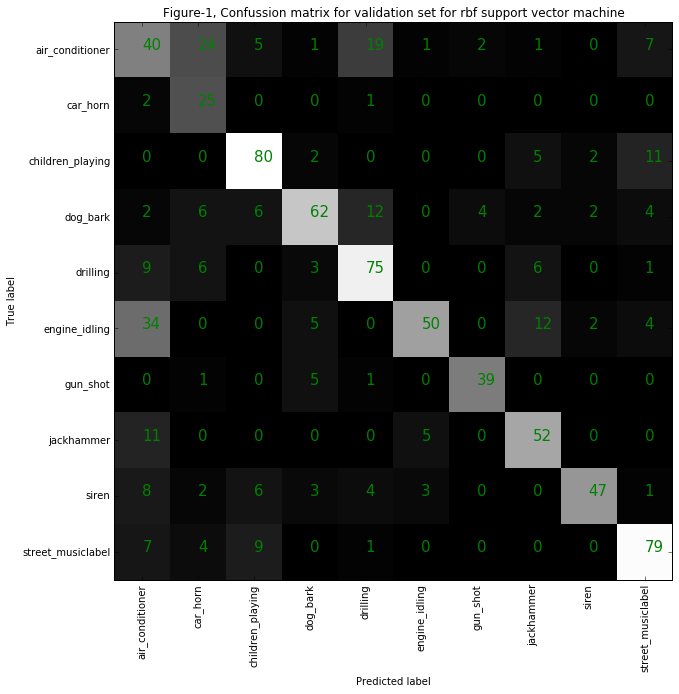

In [84]:
# Plotting the confussion matrix for SVM results.
cm = sklearn.metrics.confusion_matrix(test_labels, predictions_svm)
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(cm, interpolation='nearest', cmap='gray')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=15, color='green')
ax.set_xticks(range(len(cm)))
ax.set_xticklabels(labels,rotation='vertical')
ax.set_yticks(range(len(cm)))
ax.set_yticklabels(labels)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
ax.set_title('Figure-1, Confussion matrix for validation set for rbf support vector machine')
plt.show()

There is difference in the confussion matrix from validation set. 

Model did not perform much better as the maximum number of wrong classification is still 34 (label5 ('engine idilling') and label0('air conditioner'). The accuracy is nearly same as that of validation set.

**Qualitative analysis**
* Choosing 3 audio files that were miss-classified in Step 1 and playing them to listen and try to understand reason of misclassification



In [108]:
prediction

'2'

In [112]:
# Find the audio samples that werew mis classified for listning and identifying the reason.
index = 0
for filename, prediction, label in zip(test_files, predictions, test_labels):
    if prediction != label:
        print "{:d} {:s} is {:s} but was classified as {:s}".format(
            index, os.path.basename(filename), labels[int(label)], labels[int(prediction)])
    index += 1

0 101281-3-0-0.wav is dog_bark but was classified as children_playing
1 101281-3-0-14.wav is dog_bark but was classified as street_musiclabel
2 101281-3-0-5.wav is dog_bark but was classified as street_musiclabel
6 104327-2-0-28.wav is children_playing but was classified as siren
7 104327-2-0-3.wav is children_playing but was classified as siren
8 104327-2-0-30.wav is children_playing but was classified as siren
9 104327-2-0-34.wav is children_playing but was classified as siren
10 104327-2-0-4.wav is children_playing but was classified as siren
11 105319-3-0-22.wav is dog_bark but was classified as street_musiclabel
12 105319-3-0-29.wav is dog_bark but was classified as air_conditioner
13 105319-3-0-39.wav is dog_bark but was classified as street_musiclabel
14 106486-5-0-0.wav is engine_idling but was classified as street_musiclabel
15 106486-5-0-1.wav is engine_idling but was classified as street_musiclabel
16 106486-5-0-2.wav is engine_idling but was classified as street_musiclabel


3 files selected for listening to audio and identifying the reason are:

[729] -->  file name -78651-5-0-8.wav is label5 but was classified as label0 --- Selected this pair as it has maximum number of mis-classification.

[134] -->  file name -129356-2-0-118.wav is label2 but was classified as label9

[286] -->  file name -164311-3-0-0.wav is label3 but was classified as label4



Listening to each file and suggest a possible explanation for why the model miss-classified it based on how it sounds.

In [125]:
# getting the audio file for index 729
audio_err, _ = librosa.load(test_files[813], sr=samplerate)

In [126]:
#  initiating the audio playback
Audio(audio_err, rate=samplerate)

**File 78651-5-0-8.wav, index 729 is label 5 but was classified as label 0**

The probable reason could be its periodic knocking voice of ingine ideling which is very similar to the sound of the air conditioner(label0)

In [45]:
# getting the audio file for index 134
audio_err, _ = librosa.load(test_files[134], sr=samplerate)

In [46]:
#  initiating the audio playback
Audio(audio_err, rate=samplerate)

**File '129356-2-0-118.wav', index 134 is label2(children playing) but was classified as label9(street mislanious)**

The probable reason could be lot of background sounds that is most common with label9

In [53]:
# getting the audio file for index 305
audio_err, _ = librosa.load(test_files[279], sr=samplerate)

In [54]:
#  initiating the audio playback
Audio(audio_err, rate=samplerate)

**File 166931-4-3-1.wav, index 305,  is label 4 but was classified as label 1**

The probable reason could the echo in the dog bark and dog is barking and then there is some kind of noise still coming to mic that machine might have predicted simmilar to engine ideling which is knocking sound with continous background

